<a href="https://colab.research.google.com/github/drwatson93/M2_A2/blob/main/Assigment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This assignment is to learn how to build and evaluate classificationmodels. The goal is to select and train a classificationmodel “default of credit card clients”dataset. The data is taken from https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients. You can download the Excel file from this link: https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls.

In [47]:
import numpy as np
import pandas as pd

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# SKlearn imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve


In [48]:
cc_default_data = pd.read_excel('https://github.com/drwatson93/M2_A2/blob/main/default%20of%20credit%20card%20clients.xls?raw=true', skiprows=1)
cc_default_data.drop(['ID'], axis=1, inplace=True)
cc_default_data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


Part 1:

In [49]:
# 1. Explore the data
cc_default_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

In [50]:
# Categorical variables description
cc_default_data[['SEX', 'EDUCATION', 'MARRIAGE']].describe()

,SEX,EDUCATION,MARRIAGE
count,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867
std,0.489129,0.790349,0.521970
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


No missing data, but a few anomalous things:

*   EDUCATION has category 5 and 6 that are unlabelled, moreover the category 0 is undocumented.
*   MARRIAGE has a label 0 that is undocumented

In [51]:
# Payment delay description
cc_default_data[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


They all present an undocumented label -2. If 1,2,3, etc are the months of delay, 0 should be labeled 'pay duly' and every negative value should be seen
as a 0. But we will get to that later

In [52]:
# Bill Statement description
cc_default_data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


Negative values can be interpreted as credit? Has to be investigated



In [53]:
#Previous Payment Description
cc_default_data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [54]:
cc_default_data.LIMIT_BAL.describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

The range is very broad, Investigation required.

In [55]:
# probability of default
cc_default_data['default payment next month'].sum() / len(cc_default_data['default payment next month'])

0.2212

In [56]:
# 2. Follow similar procedure as the one for Assignment 1(End-to-end Machine Learning Project).

In [57]:
# 3. Do you require any data pre-processing? Are all the features useful? (Don’t create newfeatures). Please note the categorical features ("SEX", "EDUCATION", "MARRIAGE").

In [58]:
cc_default_data = cc_default_data.rename(columns={'default payment next month': 'def_pay', 
                        'PAY_0': 'PAY_1'})
cc_default_data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,def_pay
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [59]:
edu_fix = (cc_default_data.EDUCATION == 5) | (cc_default_data.EDUCATION == 6) | (cc_default_data.EDUCATION == 0)
cc_default_data.loc[edu_fix, 'EDUCATION'] = 4
cc_default_data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [60]:
cc_default_data.loc[cc_default_data.MARRIAGE == 0, 'MARRIAGE'] = 3
cc_default_data.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61e550ba10>,
      dtype=object)

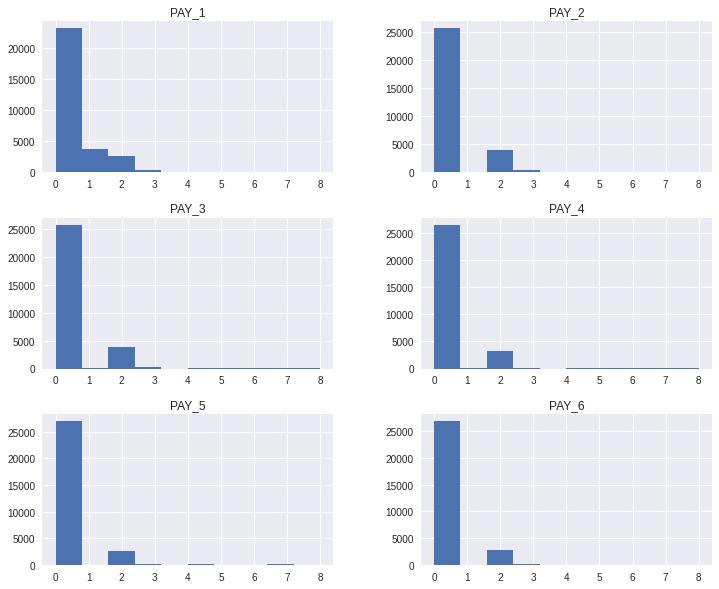

In [61]:
# According to our documentation, the PAY_n variables indicate the number of months of delay and indicates "pay duly"with -1. 
# Then what is -2? And what is 0? It seems to me the label has to be adjusted to 0 for pay duly.

pay_fix = (cc_default_data.PAY_1 == -2) | (cc_default_data.PAY_1 == -1) | (cc_default_data.PAY_1 == 0)
cc_default_data.loc[pay_fix, 'PAY_1'] = 0
pay_fix = (cc_default_data.PAY_2 == -2) | (cc_default_data.PAY_2 == -1) | (cc_default_data.PAY_2 == 0)
cc_default_data.loc[pay_fix, 'PAY_2'] = 0
pay_fix = (cc_default_data.PAY_3 == -2) | (cc_default_data.PAY_3 == -1) | (cc_default_data.PAY_3 == 0)
cc_default_data.loc[pay_fix, 'PAY_3'] = 0
pay_fix = (cc_default_data.PAY_4 == -2) | (cc_default_data.PAY_4 == -1) | (cc_default_data.PAY_4 == 0)
cc_default_data.loc[pay_fix, 'PAY_4'] = 0
pay_fix = (cc_default_data.PAY_5 == -2) | (cc_default_data.PAY_5 == -1) | (cc_default_data.PAY_5 == 0)
cc_default_data.loc[pay_fix, 'PAY_5'] = 0
pay_fix = (cc_default_data.PAY_6 == -2) | (cc_default_data.PAY_6 == -1) | (cc_default_data.PAY_6 == 0)
cc_default_data.loc[pay_fix, 'PAY_6'] = 0
late = cc_default_data[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
late.hist(figsize=(12,10))

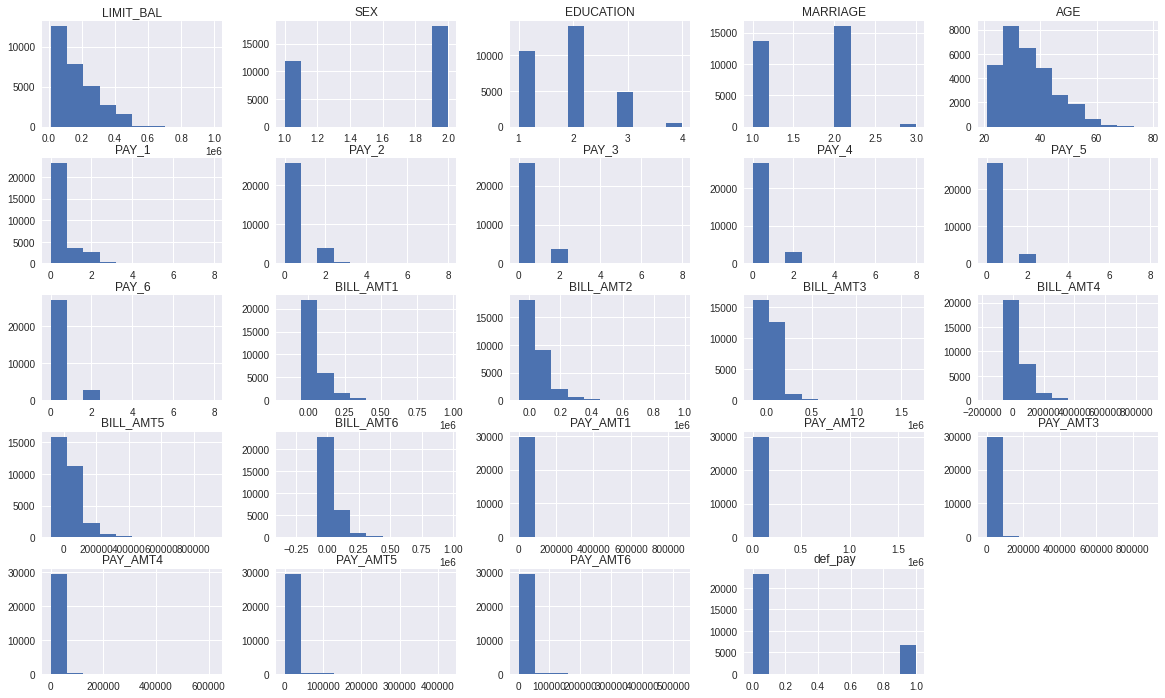

In [62]:
# 4. Plot the distribution of labels. Can you use accuracy to evaluate the results?
cc_default_data.hist(figsize=(20,12))
plt.show()

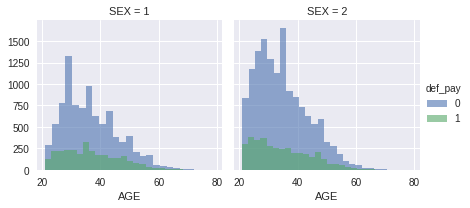

In [63]:
g = sns.FacetGrid(cc_default_data, col='SEX', hue='def_pay')
g.map(plt.hist, 'AGE', alpha=0.6, bins=25)
g.add_legend()

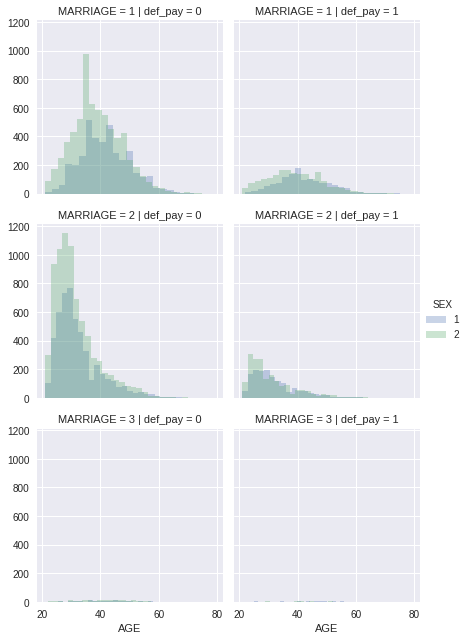

In [64]:
g = sns.FacetGrid(cc_default_data, col='def_pay', row= "MARRIAGE", hue='SEX')
g.map(plt.hist, 'AGE', alpha=0.3, bins=25) 
g.add_legend()

No accuracy will not work as the data is skewed to the right.

In [65]:
# 5. Set the random seed to 2021(For splitting or any other random algorithm)
RANDOM_STATE = 2021
np.random.seed(RANDOM_STATE)

In [66]:
cc_default_data_no_labels = cc_default_data.drop('def_pay', axis=1).copy()

num_attribs = ['LIMIT_BAL', 'AGE',	'PAY_1',	'PAY_2',	'PAY_3',	'PAY_4',	'PAY_5',	'PAY_6',	'BILL_AMT1',	'BILL_AMT2',	'BILL_AMT3',	'BILL_AMT4',	'BILL_AMT5',	'BILL_AMT6',	'PAY_AMT1',	'PAY_AMT2',	'PAY_AMT3',	'PAY_AMT4',	'PAY_AMT5', 'PAY_AMT6']
cat_attribs = ['SEX', 'EDUCATION', 'MARRIAGE']

full_pipeline = ColumnTransformer([
        ("std_scaler", StandardScaler(), num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

cc_default_data_prepared = full_pipeline.fit_transform(cc_default_data_no_labels)

In [67]:
cc_default_data_prepared[0]

array([-1.13672015, -1.24601985,  2.16049607,  2.0954688 , -0.38461417,
       -0.33999038, -0.30862144, -0.31668782, -0.64250107, -0.64739923,
       -0.66799331, -0.67249727, -0.66305853, -0.65272422, -0.34194162,
       -0.22708564, -0.29680127, -0.30806256, -0.31413612, -0.29338206,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ])

In [68]:
# 6. Split data into training (80%) and testing (20%)
from sklearn.model_selection import train_test_split

cc_default_data_train_set, cc_default_data_test_set, cc_default_label_train_set, cc_default_label_test_set = train_test_split(cc_default_data_prepared, cc_default_data['def_pay'], test_size=0.2, random_state=RANDOM_STATE)



In [69]:
# Definition for grid search.
def gridsearch(model, params):
    gs = GridSearchCV(model, params, verbose = 2, cv = 5, scoring = 'roc_auc', n_jobs = -1)
    gs.fit(cc_default_data_train_set, cc_default_label_train_set)
    print('\nBest params: ', gs.best_params_)
    print('\nBest estimator: ', gs.best_estimator_,)
    print('\nBest auc on training set: ', gs.best_score_)
    print('\nBest auc on test set: ', gs.score(cc_default_data_test_set, cc_default_label_test_set))
    return gs.best_estimator_

# Defenition to plot ROC.
def plot_roc(prob):
    y_score = prob
    fpr = dict()
    tpr = dict()
    roc_auc=dict()
    fpr[1], tpr[1], _ = roc_curve(cc_default_label_test_set, y_score)
    roc_auc[1] = auc(fpr[1], tpr[1])

    plt.figure(figsize=[9,7])
    plt.plot(fpr[1], tpr[1], 
    label='Roc curve (area=%0.2f)' %roc_auc[1], linewidth=4)
    plt.plot([1,0], [1,0], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('false positive rate', fontsize=18)
    plt.ylabel('true positive rate', fontsize=18)
    plt.title('ROC curve for credit default', fontsize=18)
    plt.legend(loc='lower right')
    plt.show()

In [70]:
# 7. Train a KNN Classifier and choose the best “n_neighbors” using grid search cross validation. Use “roc_auc” as the validation score and select “n_neighbors” from [5, 10, 20, 50, 100, 500].
knn = KNeighborsClassifier()
grid_params = {
    'n_neighbors': [5, 10, 20, 50, 100, 500],
    #'weight': ['uniform'],
    #'metric': ['euclidean']
}

best_knn_model = gridsearch(knn, grid_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished



Best params:  {'n_neighbors': 100}

Best estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

Best auc on training set:  0.761374581368288

Best auc on test set:  0.7598780093942514


<Figure size 864x720 with 0 Axes>

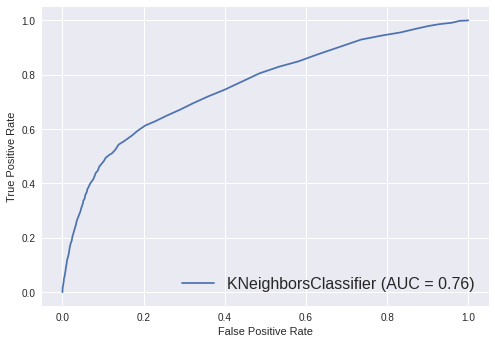

In [71]:
#y_probas_KNN = cross_val_predict(best_knn_model, cc_default_data_train_set, cc_default_label_train_set, cv=5, method='predict_proba')
#y_scores_KNN = y_probas_KNN[:, 1]
#fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(cc_default_label_train_set, y_scores_KNN)

plt.figure(figsize = (12,10))
plot_roc_curve(best_knn_model, cc_default_data_test_set, cc_default_label_test_set)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [72]:
# 8. Train a Random Forest Classifier with default parameters except “n_estimators”. 
# Choose the best “n_estimators” among [10, 20, 50, 100, 500] using Grid Search cross validation. Use “roc_auc” as the validation score.

rfr = RandomForestClassifier()
grid_params = {
    'n_estimators': [10, 20, 50, 100, 500],
    #'weight': ['uniform'],
    #'metric': ['euclidean']
}

best_rfr_model = gridsearch(rfr, grid_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished



Best params:  {'n_estimators': 500}

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Best auc on training set:  0.7666287260444141

Best auc on test set:  0.7701170132273057


<Figure size 864x720 with 0 Axes>

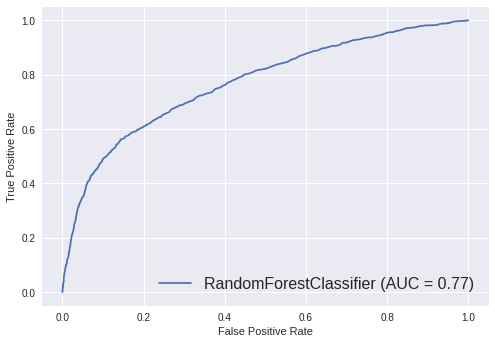

In [73]:
#y_probas_RFR = cross_val_predict(best_rfr_model, cc_default_data_train_set, cc_default_label_train_set, cv=5, method='predict_proba')
#y_scores_RFR = y_probas_RFR[:, 1]
#fpr_RFR, tpr_RFR, thresholds_RFR = roc_curve(cc_default_label_train_set, y_scores_RFR)

plt.figure(figsize = (12,10))
plot_roc_curve(best_rfr_model, cc_default_data_test_set, cc_default_label_test_set)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [74]:
# 9. Train a Logistic Regression classifier with default parameters.
lr = LogisticRegression(solver='liblinear')

grid_params = {'C': [0.001, 0.01, 0.1, 1, 10], 
               'class_weight': [None, 'balanced'], 
               'penalty': ['l1', 'l2']
               }

best_lr_model = gridsearch(lr, grid_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.0s finished



Best params:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}

Best estimator:  LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Best auc on training set:  0.7604532855942931

Best auc on test set:  0.7628002832198437


<Figure size 864x720 with 0 Axes>

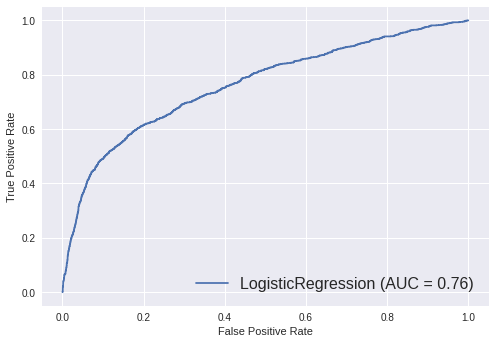

In [75]:
#y_probas_LR = cross_val_predict(best_lr_model, cc_default_data_train_set, cc_default_label_train_set, cv=5, method='predict_proba')
#y_scores_LR = y_probas_LR[:, 1]
#fpr_LR, tpr_LR, thresholds_LR = roc_curve(cc_default_label_train_set, y_scores_LR)

plt.figure(figsize = (12,10))
plot_roc_curve(best_lr_model, cc_default_data_test_set, cc_default_label_test_set)
plt.legend(loc="lower right", fontsize=16)
plt.show()

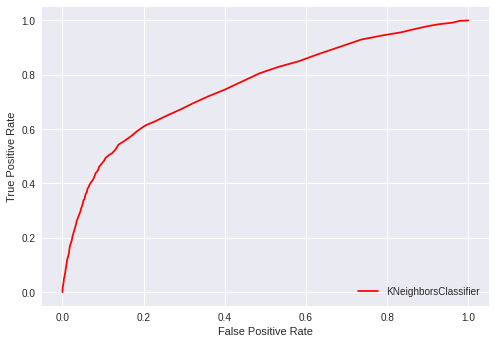

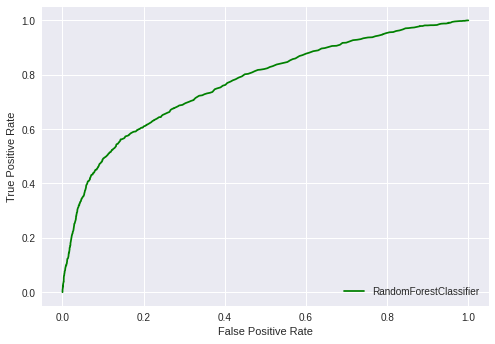

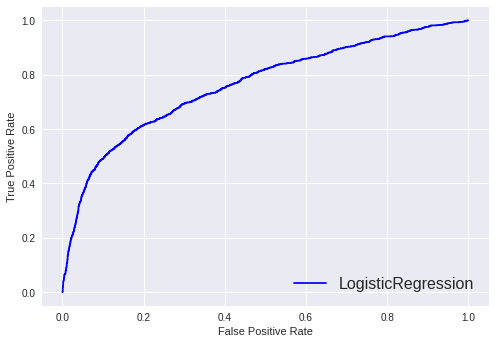

In [76]:
# 10. Plot ROC curves for all three models (use best models selected for KNN and Random Forest) on one graph. Analyze it and choose which one is a better classifier.
#plt.figure(figsize=(12,10))

plot_roc_curve(best_knn_model, cc_default_data_test_set, cc_default_label_test_set, color='r', label="KNeighborsClassifier")
plot_roc_curve(best_rfr_model, cc_default_data_test_set, cc_default_label_test_set, color='g', label="RandomForestClassifier")
plot_roc_curve(best_lr_model, cc_default_data_test_set, cc_default_label_test_set, color='b', label="LogisticRegression")
plt.legend(loc="lower right", fontsize=16)

plt.show()

Part 2:

In [77]:
# 2. Pick the Random Forest classifier with selected “n_estimators” from part 1

rfc = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

[learning_curve] Training set sizes: [ 1920  6240 10560 14880 19200]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:  2.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.9min finished
No handles with labels found to put in legend.


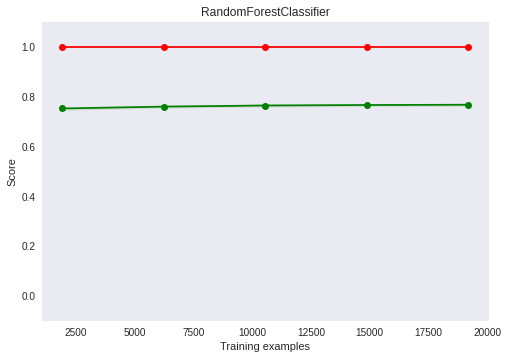

In [78]:
# 3. Plot the learning curve. Use “roc_auc” as the evaluation score.
train_sizes, train_scores, test_scores = learning_curve(best_rfr_model, cc_default_data_train_set, cc_default_label_train_set, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),cv=5, verbose=2, scoring='roc_auc')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("RandomForestClassifier")
plt.legend(loc="best")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()
    
# box-like grid
plt.grid()
    
# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label='Cross-validation score')
    
# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.show()